# 📦 Importing Libraries

In [62]:
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils import clip_grad_norm_
from torch.optim import Adam,lr_scheduler
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.nn.parallel import DataParallel
import torchvision.models as models
from PIL import Image
import numpy as np
from tqdm import tqdm
import faiss
import os
import pickle
import random
import time
import cv2
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True
np.object = np.object_
np.int = np.int_
np.bool = np.bool_

# Triplet Selection and Loading

In [63]:
class Triplet:
    def __init__(self, train_folder):
        self.train_folder = train_folder
        self.labels = [label for label in os.listdir(train_folder) if label != '.ipynb_checkpoints']
        self.label_to_path = {label: os.path.join(train_folder, label) for label in self.labels}

    def get_triplet(self):
        anchor_label = random.choice(self.labels)
        anchor_path = random.choice(os.listdir(self.label_to_path[anchor_label]))
        positive_label = anchor_label
        positive_path = random.choice(os.listdir(self.label_to_path[positive_label]))
        negative_label = random.choice([label for label in self.labels if label != anchor_label])
        negative_path = random.choice(os.listdir(self.label_to_path[negative_label]))

        anchor_image = os.path.join(self.label_to_path[anchor_label], anchor_path)
        positive_image = os.path.join(self.label_to_path[positive_label], positive_path)
        negative_image = os.path.join(self.label_to_path[negative_label], negative_path)

        anchor_label_num = self.labels.index(anchor_label)
        positive_label_num = self.labels.index(positive_label)
        negative_label_num = self.labels.index(negative_label)

        return anchor_image, positive_image, negative_image

class TripletDataset(Dataset):
    def __init__(self, train_folder, length, transform=None,):
        self.triplet_generator = Triplet(train_folder)
        self.transform = transform
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        anchor_image, positive_image, negative_image = self.triplet_generator.get_triplet()
        anchor = self._load_image(anchor_image)
        positive = self._load_image(positive_image)
        negative = self._load_image(negative_image)
        return anchor, positive, negative

    def _load_image(self, image_path):
        image = Image.open(image_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image

    def get_triplet_names(self, index):
        anchor_image, positive_image, negative_image = self.triplet_generator.get_triplet()
        return anchor_image, positive_image, negative_image

# Training with Omniglot

In [ ]:
bs = 16
train_folder = "/kaggle/input/omniglot/images_evaluation/Atlantean/"

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),           # Convert to a PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the tensor
])
#31553
train_dataset = TripletDataset(train_folder, 520, transform=transform, )
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

# Model : ResNet50

In [68]:
import torch
import torch.nn as nn
import torchvision.models as models

class TEmbeddingNet(nn.Module):
    def __init__(self, modelt):
        super(TEmbeddingNet, self).__init__()
        self.modelt = modelt
        self.feature_extractor = nn.Sequential(*list(modelt.children())[:-1])

    def forward(self, x):
        features = self.feature_extractor(x)
        return features

    def get_embedding(self, x):
        # Forward pass to get the embedding
        return self.forward(x)

resnet50 = models.resnet50(pretrained=True)
tmodel = TEmbeddingNet(resnet50)

# CHECKING EMBEDDING

In [71]:
sample_image = torch.randn(1, 3, 224, 224)  # Change the shape and size as needed
embedding = tmodel.get_embedding(sample_image)
print(embedding.shape)  # Print the shape of the embedding

torch.Size([1, 2048, 1, 1])


# TRIPLET WRAPPER

In [73]:
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.enet = embedding_net

    def forward(self, x1, x2=None, x3=None):
        if x2 is None and x3 is None:
            return self.enet.get_embedding(x1)
        return self.enet.get_embedding(x1),self.enet.get_embedding(x2),self.enet.get_embedding(x3)

    def get_embedding(self, x):
        return self.enet.get_embedding(x)

# TRIPLET LOSS

In [74]:
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = torch.norm(anchor - positive, dim=1)
        distance_negative = torch.norm(anchor - negative, dim=1)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

# DEVICE : CUDA

In [75]:
model = TripletNet(tmodel)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(TripletNet(tmodel))
else:
    model = TripletNet(tmodel)
# Move the model to the selected device (CPU or GPU)
model = model.to(device)

In [77]:
margin = 1
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)  # Learning rate scheduler
loss_fn = TripletLoss(margin)
clip_value = 0.5  # You can adjust this value as needed

# FIT

In [78]:
def fit(model, num_epochs, train_loader, bs):
    for epoch in range(n_epochs):
        start = time.time()
        model.train()
        train_loss = 0.0

        for idx, batch in enumerate(train_loader):
            anchor, positive, negative = batch
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            optimizer.zero_grad()
            anchor_embedding, positive_embedding, negative_embedding = model(anchor, positive, negative)
            anchor_embedding.requires_grad_(True)
            positive_embedding.requires_grad_(True)
            negative_embedding.requires_grad_(True)
            loss = loss_fn(anchor_embedding, positive_embedding, negative_embedding)
            loss.backward()
            clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            train_loss += loss.item()
        print(f"Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss / len(train_loader):.4f}, TIME: {time.time()-start}")
        scheduler.step()


fit(model, n_epochs:=int(input("NO OF EPOCHS : ")), train_loader, bs)

NO OF EPOCHS :  10


Epoch 1/10, Train Loss: 0.3289, TIME: 15.207762241363525
Epoch 2/10, Train Loss: 0.1265, TIME: 13.090376138687134
Epoch 3/10, Train Loss: 0.1708, TIME: 12.95472764968872
Epoch 4/10, Train Loss: 0.0945, TIME: 13.177536964416504
Epoch 5/10, Train Loss: 0.0345, TIME: 13.898748397827148
Epoch 6/10, Train Loss: 0.0444, TIME: 13.336917161941528
Epoch 7/10, Train Loss: 0.0555, TIME: 13.697610139846802
Epoch 8/10, Train Loss: 0.0096, TIME: 16.06326651573181
Epoch 9/10, Train Loss: 0.0112, TIME: 13.185798168182373
Epoch 10/10, Train Loss: 0.0140, TIME: 12.850182294845581


# GENERALIZATION TEST ON MNIST

In [80]:
class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_paths = []
        self.labels = []

        self._load_images()

    def _load_images(self):
        valid_extensions = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
        for class_name in os.listdir(self.folder_path):
            class_folder = os.path.join(self.folder_path, class_name)
            if os.path.isdir(class_folder):
                for filename in os.listdir(class_folder):
                    if filename.lower().endswith(valid_extensions):
                        self.image_paths.append(os.path.join(class_folder, filename))
                        self.labels.append(class_name)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

In [81]:
train_folder = "/kaggle/input/mnist-3456/MNIST-3456/train"
train_dataloader = DataLoader(CustomDataset(train_folder,transform=transform))
test_folder = "/kaggle/input/mnist-3456/MNIST-3456/test"
test_dataloader = DataLoader(CustomDataset(test_folder,transform=transform))

# EMBEDDINGS EXTRACTION

In [82]:
start = time.time()
train_embs = None
train_labels = []
for i in tqdm(train_dataloader):
    I, L = i
    train_labels.append(L)
    emb = tmodel(I.to(device)) # Assuming `model_loaded(I)` returns a PyTorch tensor
    emb = emb.detach()
    if train_embs is None:
        train_embs = emb
    else:
        train_embs = torch.cat((train_embs, emb), dim=0)
print(time.time()-start)

100%|██████████| 4000/4000 [01:06<00:00, 60.21it/s]

66.44267153739929


In [83]:
start = time.time()
test_embs = None
test_labels = []
for i in tqdm(test_dataloader):
    I, L = i
    try:
        emb = tmodel(I.to(device)) # Assuming `model_loaded(I)` returns a PyTorch tensor
        emb = emb.detach()
        if test_embs is None:
            test_embs = emb
        else:
            test_embs = torch.cat((test_embs, emb), dim=0)
        test_labels.append(L)
    except:
        print("ERROR")
print(time.time()-start)

100%|██████████| 400/400 [00:07<00:00, 57.02it/s]

7.018407821655273


# CREATING AN INDEX

In [84]:
embs_cpu_np = train_embs.cpu().numpy()
embs_cpu_np = embs_cpu_np.reshape(embs_cpu_np.shape[0], -1)
index = faiss.IndexHNSWFlat(embs_cpu_np.shape[1], 32)  # M = 32 for the HNSW index
index.add(embs_cpu_np)

In [85]:
def evaluate_with_faiss(embs, index):
    TOTAL = len(embs)
    CORRECT = 0
    start = time.time()
    
    # Initialize the tqdm progress bar
    with tqdm(total=TOTAL) as pbar:
        for idx, emb in enumerate(embs):
            label = index.search(emb.reshape(1, -1), 1)[1][0][0]
            if train_labels[label][0] == test_labels[idx][0]:
                CORRECT += 1
            pbar.update(1)  # Update the progress bar

    accuracy = (CORRECT / TOTAL) * 100
    elapsed_time = time.time() - start
    return f'Accuracy: {CORRECT}/{TOTAL} = {accuracy:.2f}%, Time: {elapsed_time:.2f} seconds'


In [86]:
embs2_cpu_np = test_embs.cpu().numpy()
embs2_cpu_np = embs2_cpu_np.reshape(embs2_cpu_np.shape[0], -1)

In [87]:
print(f'IndexHNSWFlat : {evaluatewithfaiss(embs2_cpu_np,index)}')

1/400=0.25 TIME = 0.0012936592102050781 SECONDS
2/400=0.5 TIME = 0.0026352405548095703 SECONDS
3/400=0.75 TIME = 0.003779172897338867 SECONDS
4/400=1.0 TIME = 0.00493931770324707 SECONDS
5/400=1.25 TIME = 0.00604557991027832 SECONDS
6/400=1.5 TIME = 0.007395029067993164 SECONDS
7/400=1.7500000000000002 TIME = 0.008457660675048828 SECONDS
8/400=2.0 TIME = 0.009461164474487305 SECONDS
9/400=2.25 TIME = 0.010467290878295898 SECONDS
10/400=2.5 TIME = 0.011565923690795898 SECONDS
11/400=2.75 TIME = 0.012490034103393555 SECONDS
12/400=3.0 TIME = 0.013303995132446289 SECONDS
13/400=3.25 TIME = 0.014197349548339844 SECONDS
14/400=3.5000000000000004 TIME = 0.014865398406982422 SECONDS
15/400=3.75 TIME = 0.015677213668823242 SECONDS
16/400=4.0 TIME = 0.016638755798339844 SECONDS
17/400=4.25 TIME = 0.017444849014282227 SECONDS
18/400=4.5 TIME = 0.018506526947021484 SECONDS
19/400=4.75 TIME = 0.019501447677612305 SECONDS
20/400=5.0 TIME = 0.020639419555664062 SECONDS
21/400=5.25 TIME = 0.021710157

# ACCURACY : 99%

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/tmp/ipykernel_32/3634554069.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(train_embs_tsne[:, 0], train_embs_tsne[:, 1], c=train_labels_numeric, cmap=plt.cm.get_cmap("jet", 10))  # Adjust colormap as needed


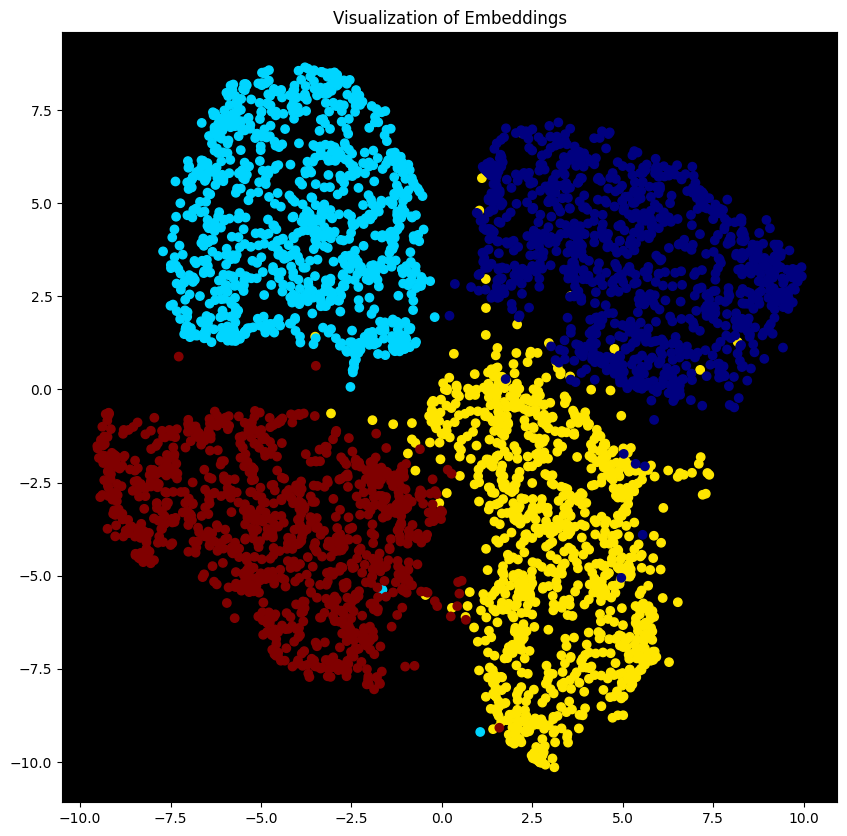

In [88]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# Step 1: Apply PCA for dimensionality reduction (optional but recommended)
# Reshape train_embs to 2D
train_embs_2d = train_embs.view(train_embs.shape[0], -1).cpu().numpy()
pca = PCA(n_components=50)  # You can choose the number of components you want
train_embs_pca = pca.fit_transform(train_embs_2d)

# Step 2: Apply t-SNE for further dimensionality reduction and visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)  # Adjust parameters as needed
train_embs_tsne = tsne.fit_transform(train_embs_pca)

# Step 3: Convert labels to numeric format using LabelEncoder
label_encoder = LabelEncoder()
train_labels_numeric = label_encoder.fit_transform(train_labels)

# Step 4: Create a dark background scatter plot
plt.figure(figsize=(10, 10))
plt.gca().set_facecolor('black')
plt.scatter(train_embs_tsne[:, 0], train_embs_tsne[:, 1], c=train_labels_numeric, cmap=plt.cm.get_cmap("jet", 10))  # Adjust colormap as needed
plt.title("Visualization of Embeddings")
plt.show()